# *(Brette, et, al., 2007)* COBA-HH

Implementation of the paper:

- Brette, R., Rudolph, M., Carnevale, T., Hines, M., Beeman, D., Bower, J. M., et al. (2007), Simulation of networks of spiking neurons: a review of tools and strategies., J. Comput. Neurosci., 23, 3, 349–98

which is based on the balanced network proposed by:

- Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95


Authors:

- Chaoming Wang (chao.brain@qq.com)


In [1]:
import brainpy as bp
import brainmodels as bms

## Parameters

In [2]:
num_exc = 3200
num_inh = 800
Cm = 200  # Membrane Capacitance [pF]

gl = 10.  # Leak Conductance   [nS]
g_Na = 20. * 1000
g_Kd = 6. * 1000  # K Conductance      [nS]
El = -60.  # Resting Potential [mV]
ENa = 50.  # reversal potential (Sodium) [mV]
EK = -90.  # reversal potential (Potassium) [mV]
VT = -63.
V_th = -20.

# Time constants
taue = 5.  # Excitatory synaptic time constant [ms]
taui = 10.  # Inhibitory synaptic time constant [ms]

# Reversal potentials
Ee = 0.  # Excitatory reversal potential (mV)
Ei = -80.  # Inhibitory reversal potential (Potassium) [mV]

# excitatory synaptic weight
we = 6.  # excitatory synaptic conductance [nS]

# inhibitory synaptic weight
wi = 67.  # inhibitory synaptic conductance [nS]

## Implementation 2

In [7]:
class HH(bp.NeuGroup):
  def __init__(self, size, **kwargs):
    super(HH, self).__init__(size, **kwargs)

    self.V = bp.math.Variable(El + (bp.math.random.randn(self.num) * 5 - 5))
    self.m = bp.math.Variable(bp.math.zeros(self.num))
    self.n = bp.math.Variable(bp.math.zeros(self.num))
    self.h = bp.math.Variable(bp.math.zeros(self.num))
    self.spike = bp.math.Variable(bp.math.zeros(self.num, dtype=bool))
    self.Isyn = bp.math.Variable(bp.math.zeros(size))

    self.integral = bp.odeint(self.derivative, method='exponential_euler')

  def derivative(self, V, m, h, n, t, Isyn):
    g_na = g_Na * (m * m * m) * h
    g_kd = g_Kd * (n * n * n * n)
    dVdt = (-gl * (V - El) - g_na * (V - ENa) - g_kd * (V - EK) + Isyn) / Cm

    a = 13 - V + VT
    b = V - VT - 40
    m_alpha = 0.32 * a / (bp.math.exp(a / 4) - 1.)
    m_beta = 0.28 * b / (bp.math.exp(b / 5) - 1)
    dmdt = (m_alpha * (1 - m) - m_beta * m)

    h_alpha = 0.128 * bp.math.exp((17 - V + VT) / 18)
    h_beta = 4. / (1 + bp.math.exp(-(V - VT - 40) / 5))
    dhdt = (h_alpha * (1 - h) - h_beta * h)

    c = 15 - V + VT
    n_alpha = 0.032 * c / (bp.math.exp(c / 5) - 1.)
    n_beta = .5 * bp.math.exp((10 - V + VT) / 40)
    dndt = (n_alpha * (1 - n) - n_beta * n)

    return dVdt, dmdt, dhdt, dndt

  def update(self, _t, _dt):
    V, self.m[:], self.h[:], self.n[:] = self.integral(self.V, self.m, self.h, self.n, _t, self.Isyn)
    self.spike[:] = bp.math.logical_and(self.V < V_th, V >= V_th)
    self.V[:] = V
    self.Isyn[:] = 0.

In [8]:
class Syn(bp.TwoEndConn):
  target_backend = 'numpy'

  def __init__(self, pre, post, conn, E, w, tau, **kwargs):
    super(Syn, self).__init__(pre, post, conn=conn, **kwargs)

    # parameters
    self.E = E
    self.w = w
    self.tau = tau

    self.pre2post = self.conn.requires('pre2post')  # connections
    self.g = bp.math.Variable(bp.math.zeros(post.num))  # variables

    self.integral = bp.odeint(self.derivative, method='exponential_euler')

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    for pre_id in range(self.pre.num):
      if self.pre.spike[pre_id]:
        post_ids = self.pre2post[pre_id]
        for i in post_ids:
          self.g[i] += self.w
    self.post.Isyn += self.g * (self.E - self.post.V)

In [9]:
E = HH(num_exc, monitors=['spike'])
I = HH(num_inh)

E2E = Syn(pre=E, post=E, conn=bp.connect.FixedProb(prob=0.02), E=Ee, w=we, tau=taue)
E2I = Syn(pre=E, post=I, conn=bp.connect.FixedProb(prob=0.02), E=Ee, w=we, tau=taue)
I2E = Syn(pre=I, post=E, conn=bp.connect.FixedProb(prob=0.02), E=Ei, w=wi, tau=taui)
I2I = Syn(pre=I, post=I, conn=bp.connect.FixedProb(prob=0.02), E=Ei, w=wi, tau=taui)

net = bp.Network(E, I, E2E, E2I, I2I, I2E)
net = bp.math.jit(net)

Compilation used 11.0434 s.
Start running ...
Run 10.0% used 0.020 s.
Run 20.0% used 0.039 s.
Run 30.0% used 0.058 s.
Run 40.0% used 0.077 s.
Run 50.0% used 0.095 s.
Run 60.0% used 0.114 s.
Run 70.0% used 0.133 s.
Run 80.0% used 0.152 s.
Run 90.0% used 0.172 s.
Run 100.0% used 0.191 s.
Simulation is done in 0.191 s.



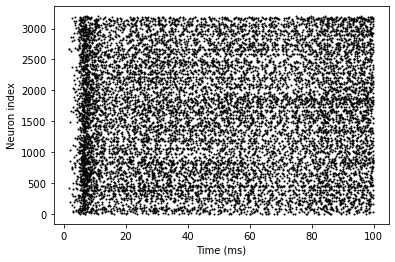

In [10]:
net.run(100., report=0.1)
bp.visualize.raster_plot(E.mon.ts, E.mon.spike, show=True)